# Обработка естественных языков
Natural Language Processing (NLP)

В рамках решения задач машинного обучения часто в качестве объектов выступают тексты на естественных языках, для которых необходимо решить задачи классификации или регресии.

В данном примере мы рассмотрим несколько подходов к извлечению признаков (feature extraction) из текстов.

В качестве тестовой задачи возьмем классификацию позитивных и негативных отзывов на фильмы (http://www.cs.cornell.edu/people/pabo/movie-review-data/)

## Загрузка данных

In [155]:
import os
import tarfile
from contextlib import closing
from urllib.request import urlopen

URL = ("http://www.cs.cornell.edu/people/pabo/"
       "movie-review-data/review_polarity.tar.gz")

URL = ("https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz")

ARCHIVE_NAME = URL.rsplit('/', 1)[1]
DATA_FOLDER = "txt_sentoken_imbd"


if not os.path.exists(DATA_FOLDER):

    if not os.path.exists(ARCHIVE_NAME):
        print("Downloading dataset from %s" % URL)
        opener = urlopen(URL)
        with open(ARCHIVE_NAME, 'wb') as archive:
            archive.write(opener.read())

    print("Decompressing %s" % ARCHIVE_NAME)
    with closing(tarfile.open(ARCHIVE_NAME, "r:gz")) as archive:
        archive.extractall(path='.')
    os.remove(ARCHIVE_NAME)

KeyboardInterrupt: 

In [151]:
from sklearn.datasets import load_files

dataset = load_files(DATA_FOLDER, encoding='utf-8', shuffle=False)
print(f"labels: {dataset.target_names}")
print(f"n_samples: {len(dataset.data)}")

labels: ['neg', 'pos']
n_samples: 2000


## Разбиение на обучающую и проверочную выборки

In [152]:
from sklearn.model_selection import train_test_split

docs_train, docs_test, y_train, y_test = train_test_split(dataset.data, dataset.target,
                                                         test_size=0.25, random_state=None)

In [150]:
!cat txt_sentoken/pos/cv000_29590.txt

films adapted from comic books have had plenty of success , whether they're about superheroes ( batman , superman , spawn ) , or geared toward kids ( casper ) or the arthouse crowd ( ghost world ) , but there's never really been a comic book like from hell before . 
for starters , it was created by alan moore ( and eddie campbell ) , who brought the medium to a whole new level in the mid '80s with a 12-part series called the watchmen . 
to say moore and campbell thoroughly researched the subject of jack the ripper would be like saying michael jackson is starting to look a little odd . 
the book ( or " graphic novel , " if you will ) is over 500 pages long and includes nearly 30 more that consist of nothing but footnotes . 
in other words , don't dismiss this film because of its source . 
if you can get past the whole comic book thing , you might find another stumbling block in from hell's directors , albert and allen hughes . 
getting the hughes brothers to direct this seems almost as 

In [153]:
docs_train[0]

'bruce barth\'s mellow piano plays in the background as conflict erupts in a little country town of florida . \nulee\'s gold feels like another fonda creation- on golden pond : it has a soft , calm surface with a tempest brewing underneath , the cinematography creates a place of gold , yellow , and olive colors , the music is stirring and tranquil . \nboth deal with the hardships of family life . \npeter fonda gives his undoubtedly best performance in victor nu ? ez\'s new film and patricia richardson ( home improvement star ) shows she is worthy of big screen attention . \nnu ? ez is probably independent film\'s greatest asset , along with john sayles , and he proves his talent with a slow pace and undulating , heavy tension . \npeter fonda\'s performance borrows from his father henry fonda\'s in on golden pond- there is a great vulnerability that he gives the character ulee jackson and just like his father , peter fonda is quiet , emotional , and weary in this exceptional role . \nul

## Методы извлечения признаков из текста

### Мешок слов (Bag of words)

Каждый текст преобразуется в вектор фиксированной размерности $m$, где $m$ - число различных слов, которые встречались во всех текстах.

Если $j$-е слово всречается в тексте $k$ раз, то при его кодировании координата с номером $j$ равна $k$.

Часто все символы слова приводят в нижний регистр, чтобы слова Thing и thing приводились к одному виду.

**Важно!** если в тестовой выборке встретилось слово, которое отсутствовало в обучающей, то оно будет проигнорированно.

### Пример

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())
print(X.toarray())

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]


In [5]:
vectorizer = CountVectorizer()
x_train = vectorizer.fit_transform(docs_train)
print(f"Размер словаря: {len(vectorizer.get_feature_names())}")

Размер словаря: 35276


При использовании мешка слов по умолчанию мы получаем признаковое пространство большой размерности, в которое входят все слова из обучающей выборки. С целью понижения размерности применяют серию приемов.

### Общеупотребимые слова

В текстах можно встречать общеупотребимые слова (предлоги, местоимения, союзы и т.д.), которые не несут прямой смысловой нагрузки для решения поставленной задачи. Эти слова логично исключить из словаря для кодирования.


In [6]:
vectorizer = CountVectorizer(stop_words='english')
x_train = vectorizer.fit_transform(docs_train)
print(f"Размер словаря: {len(vectorizer.get_feature_names())}")

Размер словаря: 34971


### Редкие слова
Следующий прием для уменьшения размерности - исключение редко встречаемых в текстах слов. Несмотря на то, что эти слова могут нести важную информацию, но их исключение может позволить значительно снизить размерность задачи.

Исключим слова, которые встречаются менее чем в 10% документов. Такое сильное огрубление необходимо, чтобы число признаков было меньше, чем число примеров обучающей выборки.

In [7]:
vectorizer = CountVectorizer(stop_words='english', min_df=0.1)
x_train = vectorizer.fit_transform(docs_train)
print(f"Размер словаря: {len(vectorizer.get_feature_names())}")

Размер словаря: 352


## Обучение модели

В качестве базовой модели возьмем логистическую регрессию.


In [8]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(x_train, y_train);

/Users/filonov_p/Dropbox/work/mstuca/ml/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Тестирование на отложенной выборке

In [9]:
x_test = vectorizer.transform(docs_test)
y_pred = logreg.predict(x_test)

In [10]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred,
                            target_names=dataset.target_names))

              precision    recall  f1-score   support

         neg       0.73      0.72      0.73       261
         pos       0.70      0.71      0.71       239

    accuracy                           0.72       500
   macro avg       0.72      0.72      0.72       500
weighted avg       0.72      0.72      0.72       500



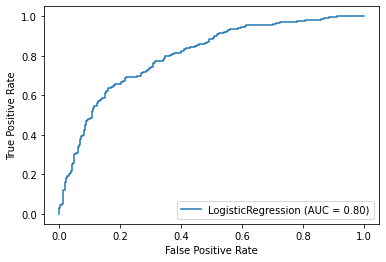

In [11]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(logreg, x_test, y_test);

## TF-IDF

Данный метод кодирования формирует вектор, коордианата которого равно произведению частоты встречаемости слова в данном тексте (term frequency) и обратной величины к встречаемости слова в других текстах (inverse document frequency)

### Пример

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print(X.toarray())

[[0.         0.46979139 0.58028582 0.38408524 0.         0.
  0.38408524 0.         0.38408524]
 [0.         0.6876236  0.         0.28108867 0.         0.53864762
  0.28108867 0.         0.28108867]
 [0.51184851 0.         0.         0.26710379 0.51184851 0.
  0.26710379 0.51184851 0.26710379]
 [0.         0.46979139 0.58028582 0.38408524 0.         0.
  0.38408524 0.         0.38408524]]


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', min_df=0.1)
x_train = vectorizer.fit_transform(docs_train)

In [18]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train);

              precision    recall  f1-score   support

         neg       0.77      0.74      0.75       261
         pos       0.73      0.77      0.75       239

    accuracy                           0.75       500
   macro avg       0.75      0.75      0.75       500
weighted avg       0.75      0.75      0.75       500



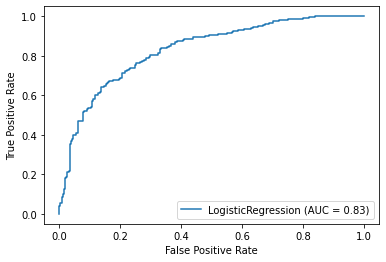

In [19]:
x_test = vectorizer.transform(docs_test)
y_pred = logreg.predict(x_test)
print(classification_report(y_test, y_pred,
                            target_names=dataset.target_names))
plot_roc_curve(logreg, x_test, y_test)

## Вложения
Embeddings

### Word2vec

In [20]:
from gensim.test.utils import common_texts

In [136]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords, wordnet

stopwords = set(stopwords.words("english"))

def to_sentences(docs):
    stemmer = PorterStemmer()
    return [[stemmer.stem(word.lower()) for word in nltk.word_tokenize(str(doc)) if word not in stopwords] for doc in docs]

sent_train = to_sentences(docs_train)

[nltk_data] Downloading package punkt to /Users/filonov_p/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/filonov_p/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/filonov_p/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
from gensim.models import Word2Vec
model = Word2Vec(sentences=sent_train, size=25, window=5, min_count=1)

In [23]:
import numpy as np

def text2vec(model, docs):
    result = np.zeros((len(docs), model.vector_size))
    for i, sentence in enumerate(docs):
        nwords = 0
        for word in sentence:
            if word in model.wv.vocab:
                result[i, :] += model.wv[word]
                nwords += 1
        result[i, :] /= nwords
    return result

In [24]:
x_train = text2vec(model, sent_train)

In [25]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train);

              precision    recall  f1-score   support

         neg       0.68      0.54      0.60       261
         pos       0.59      0.72      0.65       239

    accuracy                           0.62       500
   macro avg       0.63      0.63      0.62       500
weighted avg       0.63      0.62      0.62       500



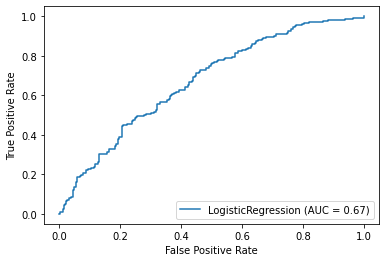

In [27]:
x_test = text2vec(model, to_sentences(docs_test))
y_pred = logreg.predict(x_test)
print(classification_report(y_test, y_pred,
                            target_names=dataset.target_names))
plot_roc_curve(logreg, x_test, y_test)

In [41]:
from gensim.models.doc2vec import TaggedDocument

def to_docs(doc):
    stemmer = PorterStemmer()
    
    return [stemmer.stem(word.lower()) for word in nltk.word_tokenize(str(doc))]

In [42]:
train_corpus = [TaggedDocument(to_docs(doc), [i]) for i, doc in enumerate(docs_train)]

In [43]:
from gensim.models.doc2vec import Doc2Vec

model = Doc2Vec(vector_size=25, min_count=2, epochs=40)

In [44]:
model.build_vocab(train_corpus)

In [45]:
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [46]:
x_train = np.array([model.infer_vector(to_docs(doc)) for doc in docs_train])

In [47]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train);

              precision    recall  f1-score   support

         neg       0.69      0.85      0.76       261
         pos       0.79      0.58      0.67       239

    accuracy                           0.72       500
   macro avg       0.74      0.72      0.72       500
weighted avg       0.74      0.72      0.72       500



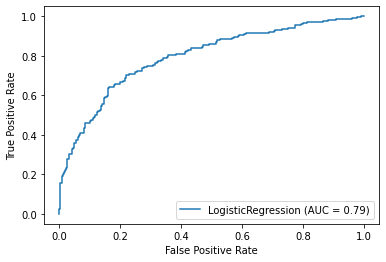

In [48]:
x_test = np.array([model.infer_vector(to_docs(doc)) for doc in docs_test])
y_pred = logreg.predict(x_test)
print(classification_report(y_test, y_pred,
                            target_names=dataset.target_names))
plot_roc_curve(logreg, x_test, y_test)

In [133]:
from keras import Sequential
from keras.layers import LSTM, Dense
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=350)

tokenizer.fit_on_texts([str(doc) for doc in docs_train])

X_train = tokenizer.texts_to_sequences([str(doc) for doc in docs_train])
X_test = tokenizer.texts_to_sequences([str(doc) for doc in docs_test])

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

X_train = to_categorical(X_train)
X_test = to_categorical(X_test)

In [134]:
from keras.metrics import BinaryAccuracy
from keras.layers import InputLayer, GRU, Dropout

model = Sequential()

model.add(
    InputLayer(input_shape=X_train.shape[1:],
              ))
model.add(
    GRU(40,
        activation='relu',
        recurrent_dropout=0.5
        ))
# model.add(
#     Dropout(0.5))
model.add(
    Dense(1,
          activation='sigmoid',
         ))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=[BinaryAccuracy()])
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, 40)                47040     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 41        
Total params: 47,081
Trainable params: 47,081
Non-trainable params: 0
_________________________________________________________________


In [135]:
history = model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          batch_size=8,
          epochs=30,
         )

Epoch 1/30
188/188 [==============================] - 15s 78ms/step - loss: 0.6940 - binary_accuracy: 0.4927 - val_loss: 0.6914 - val_binary_accuracy: 0.5260
Epoch 2/30
188/188 [==============================] - 14s 75ms/step - loss: 0.6902 - binary_accuracy: 0.5347 - val_loss: 0.6929 - val_binary_accuracy: 0.4980
Epoch 3/30
 36/188 [====>.........................] - ETA: 12s - loss: 0.6855 - binary_accuracy: 0.5625

KeyboardInterrupt: 

In [ ]:
model.predict_classes

In [ ]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred,
                            target_names=dataset.target_names))

Populating the interactive namespace from numpy and matplotlib


0.8058641530002085

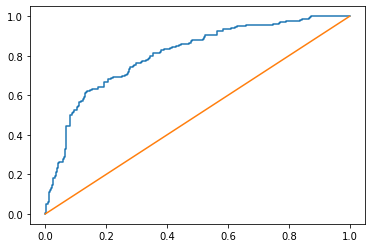

In [125]:
%pylab inline
from sklearn.metrics import roc_curve, auc

y_pred_prob = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.plot([0,1], [0, 1])
auc(fpr, tpr)

In [145]:
docs_train[1]

b'when i first heard of contact , the hype was building it up as a sci-fi blockbuster . \nnow , with that in mind , coupled with the knowledge of jodie foster\'s involvement in the project , i thought " what in the world is foster doing in a sci-fi blockbuster ? ? ? " . \nas it turned out , my expectations were completely nullified and turned topsy-turvy . \nrobert zemeckis , back from the euphoria created by his last film , forrest gump , once again proves his mastery in fusing tales of adventure with along the endearing lines of human spirit . \ndon\'t get me wrong , contact is sci-fi ? but with a definite difference . \nbased on the late carl sagan novel of the same name , the story delves itself in questions on science and god ; fact and faith . \nallie ( foster ) is a radio astronomer . \nshe spends her time listening to the stars , via ultra-huge communication dishes in search of intelligent life beyond the solar system . \nher passion for `long-distance communication\' is the re